In [1]:
import matplotlib.pyplot as plt
import numpy as np
# Make notebook fill the whole screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def rotated(angle, center, p):
    pprime = np.array(p) - np.array(center)
    coordX = np.cos(angle)*pprime[0]-np.sin(angle)*pprime[1]
    coordY = np.sin(angle)*pprime[0]+np.cos(angle)*pprime[1]
    return np.array([coordX+center[0],coordY+center[1]])

In [3]:
def genArcPointsGeneral(p1, p2, p3, numpoints=10, verbose=False):
    #find center, stolen from
    #https://stackoverflow.com/questions/4103405/what-is-the-algorithm-for-finding-the-center-of-a-circle-from-three-points
    ax = (p1[0] + p2[0]) / 2.
    ay = (p1[1] + p2[1]) / 2.
    ux = (p1[1] - p2[1])
    uy = (p2[0] - p1[0])
    bx = (p2[0] + p3[0]) / 2.
    by = (p2[1] + p3[1]) / 2.
    vx = (p2[1] - p3[1])
    vy = (p3[0] - p2[0])
    dx = ax - bx
    dy = ay - by
    vu = vx * uy - vy * ux
    g = (dx * uy - dy * ux) / vu
    center = np.array([-1.,-1.])
    center[0] = bx + g * vx
    center[1] = by + g * vy
    #find radius
    radius = np.sqrt((center[0]-p1[0])**2 + (center[1]-p1[1])**2)
    #print(f"radius: {radius}")
    #find angles of p1 and p3
    p1p3 = np.linalg.norm(np.array(p1)-np.array(p3))
    #print(f"Error in arccos: radius {radius:.4}, p1p3 {p1p3:.4}, arccos({(2*radius**2 - p1p3**2)/(2*radius**2)})")
    alpha = np.arccos((2*radius**2 - p1p3**2)/(2*radius**2))
    error_normal = np.linalg.norm(rotated(alpha,center,p1)-np.array(p3))
    error_mnormal = np.linalg.norm(rotated(-alpha,center,p1)-np.array(p3))
    errors = [error_normal, error_mnormal]
    if(error_mnormal == np.min(errors)):
        alpha *= -1
    if verbose:
        print(f"alpha: {alpha}")
    fixed = 0
    
    if verbose:
        print(f"corrected alpha: {alpha}")
    #print(f"alpha: {alpha} (error: {np.linalg.norm(rotated(alpha,center,p1)-np.array(p3)):.4})")
    angles0 = np.linspace(0,alpha,numpoints,endpoint=False)
    points0 = []
    alpha_inv = 0.
    if(alpha > 0):
        alpha_inv = alpha - 2.*np.pi
    else:
        alpha_inv = 2.*np.pi + alpha
    angles_inv = np.linspace(0, alpha_inv, numpoints, endpoint=False)
    points_inv = []
    for gamma in angles0[1:]:
        points0.append(rotated(gamma, center, p1))
    for gamma in angles_inv[1:]:
        points_inv.append(rotated(gamma, center, p1))
    
    #find minimum distance of center arc point to point in points
    mindist0 = 9999999.
    minind0 = -1
    for i,p in enumerate(points0):
        newdist = np.linalg.norm(np.array(p2)-np.array(p))
        if newdist < mindist0:
            mindist0 = newdist
            minind0 = i
    mindist_inv = 9999999.
    minind_inv = -1
    for i,p in enumerate(points_inv):
        newdist = np.linalg.norm(np.array(p2)-np.array(p))
        if newdist < mindist_inv:
            mindist_inv = newdist
            minind_inv = i
    if(abs(minind_inv-11.5) < abs(minind0-11.5)):
        return points_inv, center, 1
    else:
        return points0, center, 0
    
    

In [4]:
filename = "C:\\Users\\Pascal\\repos\\rbcomb-sample\\RBComb_Millenium\\TopLayer\\AutoCAD Scripts\\CreateDevice_Metal.scr"
num_primitives = 275000
lines = []
arclines = []
centers = []

#buffer file for faster reading
class myFile:
    def __init__(self, filename):
        with open(filename) as file:
            self.lines = file.readlines()
            self.current_line = 0
    
    def end(self):
        return self.current_line >= len(self.lines)
    
    def readline(self):
        if self.end():
            return "\n"
        self.current_line += 1
        return self.lines[self.current_line-1]

    
file = myFile(filename)
primitives_read = 0
num_fixed = 0
while(primitives_read < num_primitives and not file.end()):
    if primitives_read % 10000 == 0:
        print(f"Primitives read: {primitives_read}, fixed: {num_fixed}")
    line = file.readline()[:-1]
    if(line == ""):
        continue
    elif(line == "line"):
        #print("line")
        coordline1 = file.readline()[:-1]
        coordline2 = file.readline()[:-1]
        lines.append([[float(coordline1.split(',')[0]), float(coordline2.split(',')[0])], [float(coordline1.split(',')[1]), float(coordline2.split(',')[1])]])
    elif(line == "arc"):
        #print("arc")
        coordline1 = file.readline()[:-1]
        coordline2 = file.readline()[:-1]
        coordline3 = file.readline()[:-1]
        if primitives_read == 85416:
            print(f"index {primitives_read}")
            print(line)
            print(coordline1)
            print(coordline2)
            print(coordline3)
        p1 = np.array([float(coordline1.split(',')[0]), float(coordline1.split(',')[1])])
        p2 = np.array([float(coordline2.split(',')[0]), float(coordline2.split(',')[1])])
        p3 = np.array([float(coordline3.split(',')[0]), float(coordline3.split(',')[1])])
        #lines.append([[p1[0], p2[0], p3[0]], [p1[1], p2[1], p3[1]]])
        #arcpts, center, fixed = genArcPoints(p1, p2, p3, 25)
        arcpts, center, fixed = genArcPointsGeneral(p1, p2, p3, 25)
        num_fixed += fixed
        xs = [p1[0]]
        ys = [p1[1]]
        for ap in arcpts:
            xs.append(ap[0])
            ys.append(ap[1])
        xs.append(p3[0])
        ys.append(p3[1])
        #arclines.append([xs, ys])
        lines.append([xs, ys])
        centers.append(center)
    else:
        print(f"Unknown line: {line}")
    #print(line)
    primitives_read += 1

print(f"Fixed {num_fixed} arcs.")



Primitives read: 0, fixed: 0
Primitives read: 10000, fixed: 0
Primitives read: 10000, fixed: 0
Primitives read: 20000, fixed: 0
Primitives read: 20000, fixed: 0
Primitives read: 30000, fixed: 0
Primitives read: 40000, fixed: 0
Primitives read: 40000, fixed: 0
Primitives read: 50000, fixed: 0
Primitives read: 50000, fixed: 0
Fixed 0 arcs.


<IPython.core.display.Javascript object>


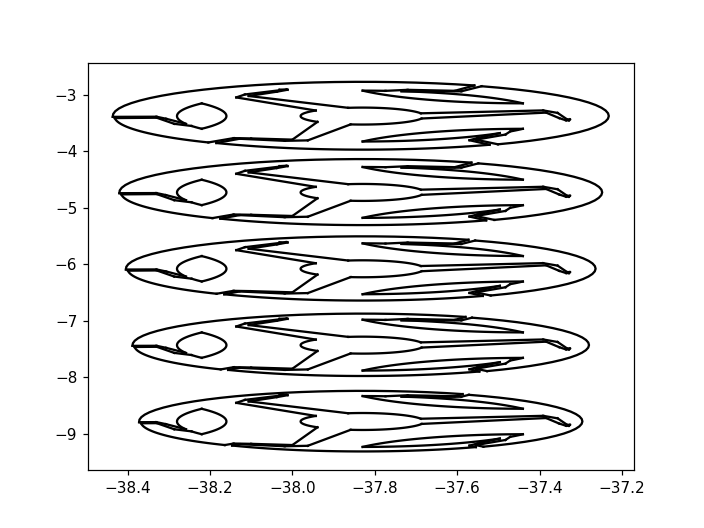

In [34]:
fig,ax = plt.subplots(1,1)
for i in range(300):
    ax.plot(lines[i][0], lines[i][1], c='black')

In [5]:
outstr = ""
nodes_processed = 0
for k,ls in enumerate(lines):
    if k % 10000 == 0:
        print(f"Processed {k} linestrips (total {len(lines)}), processed {nodes_processed} nodes")
    outstr += f"{len(ls[0])} "
    for i in range(len(ls[0])):
        outstr += f"{ls[0][i]} {ls[1][i]} "
    nodes_processed += len(ls[0])
    outstr += "\n"

outfilename = "line_strips_top.txt"
with open(outfilename, 'w') as outfile:
    outfile.write(outstr)

Processed 0 linestrips (total 58500), processed 0 nodes
Processed 10000 linestrips (total 58500), processed 83960 nodes
Processed 20000 linestrips (total 58500), processed 168016 nodes
Processed 30000 linestrips (total 58500), processed 252000 nodes
Processed 40000 linestrips (total 58500), processed 335960 nodes
Processed 50000 linestrips (total 58500), processed 420016 nodes


## Post c++ polygonization

In [35]:
polyfile = myFile("polygons_fixedarcs_top.txt")

polygons = []
for i in range(5500):
    linesplit = polyfile.readline().split(' ')
    if len(linesplit) < 4:
        continue
    newpoly = []
    for f in linesplit:
        newpoly.append(float(f))
    polygons.append(newpoly)

<IPython.core.display.Javascript object>


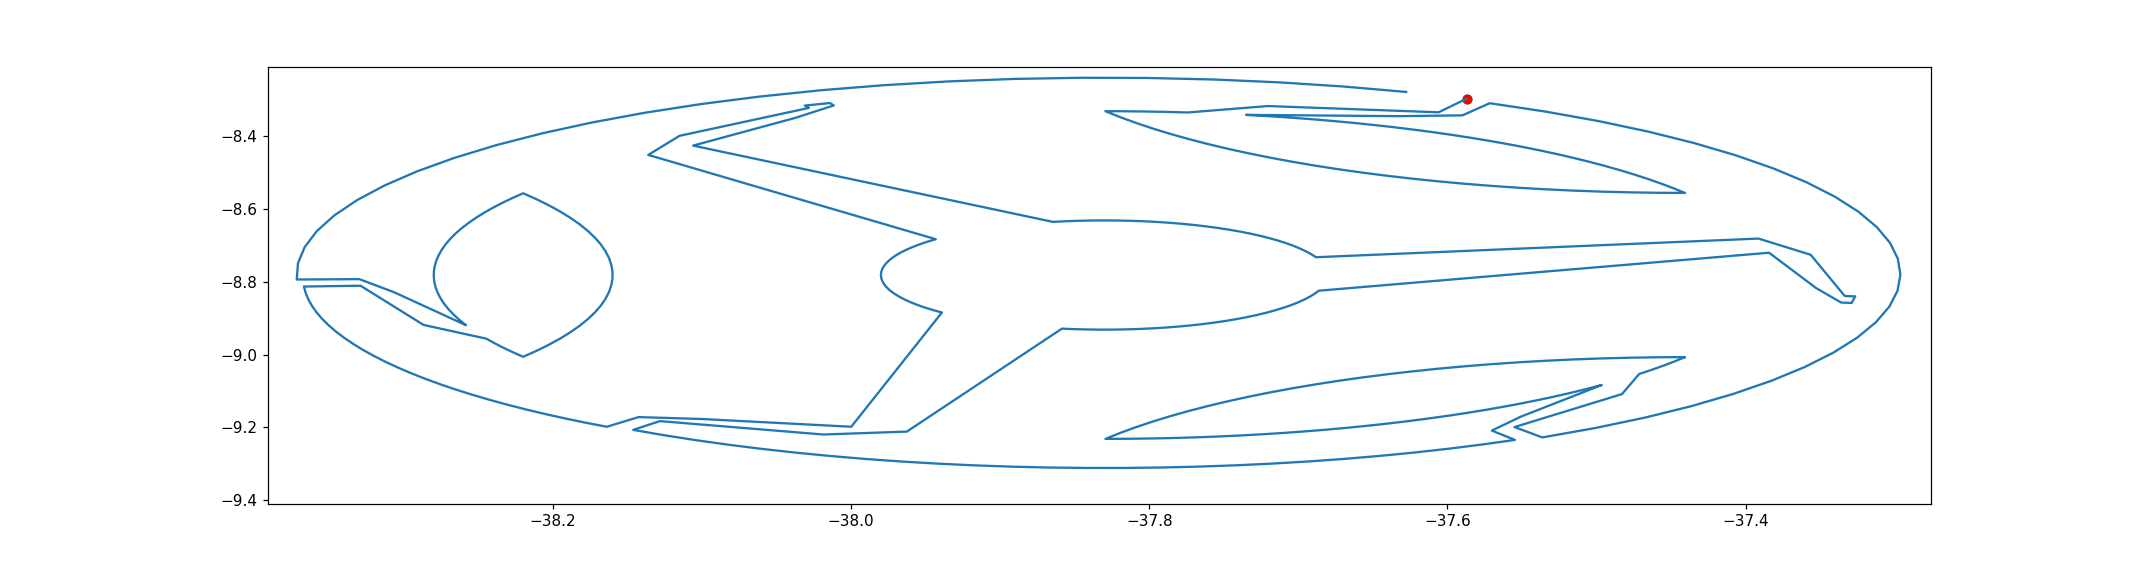

In [39]:
%matplotlib notebook
for polyindex in range(0,960):
    xs = polygons[polyindex][::2]
    ys = polygons[polyindex][1::2]
    ind = 1
    plt.plot(xs[:-ind],ys[:-ind])
    plt.scatter(xs[0], ys[0], c='g', s=30)
    plt.scatter(xs[-1], ys[-1], c='r', s=30)

In [44]:
wafer_center = np.array([0., 0.])
wafer_radius = 49.5 #5cm, 4in wafer

angles = np.linspace(0, 2.*np.pi, 1000, endpoint=False)

xy_wafer = np.array([wafer_radius*np.cos(angles), wafer_radius*np.sin(angles)])
vertices_wafer = [np.array([xy_wafer[0,i], xy_wafer[1,i]]) for i in range(1000)]

vertices_wafer_filtered = [v for v in vertices_wafer if v[1] < 13.5 and v[1] > -12.5]

In [45]:
for i,v in enumerate(vertices_wafer_filtered):
    print(f"{i} {v[1]}")

0 0.0
1 0.3110156262951681
2 0.6220189742259541
3 0.9329977659127047
4 1.2439397244452053
5 1.5548325743673503
6 1.8656640421617599
7 2.1764218567343128
8 2.487093749898593
9 2.7976674568602142
10 3.108130716701012
11 3.418471272863087
12 3.72867687363267
13 4.038735272623798
14 4.348634229261787
15 4.658361509266459
16 4.9679048851351375
17 5.277252136625366
18 5.586391051237343
19 5.895309424696053
20 6.20399506143306
21 6.512435775067984
22 6.820619388889585
23 7.1285337363364825
24 7.436166661477475
25 7.743506019491428
26 8.050539677146737
27 8.357255513280329
28 8.663641419276166
29 8.969685299543299
30 9.27537507199337
31 9.580698668517583
32 9.885644035463148
33 10.190199134109125
34 10.494351941141703
35 10.798090449128855
36 11.101402666994368
37 11.404276620491233
38 11.706700352674373
39 12.008661924372667
40 12.310149414660312
41 12.611150921327416
42 12.911654561349899
43 13.21164847135859
44 13.211648471358577
45 12.911654561349904
46 12.611150921327422
47 12.31014941466

In [46]:
x_insert_top = np.sqrt(-13.5**2+wafer_radius**2)
x_insert_bottom = np.sqrt(-12.5**2+wafer_radius**2)
vertices_wafer_filtered.insert(128, [x_insert_bottom, -12.5])
vertices_wafer_filtered.insert(128, [-x_insert_bottom, -12.5])
vertices_wafer_filtered.insert(44, [-x_insert_top, 13.5])
vertices_wafer_filtered.insert(44, [x_insert_top, 13.5])

In [47]:
from earcut import earcut
from copy import copy

In [48]:
vertices = []
for v in vertices_wafer_filtered:
    vertices.append(v[0])
    vertices.append(v[1])
hole_starts = []
for p in polygons:
    hole_starts.append(int(len(vertices)/2+0.1))
    for xory in p:
        vertices.append(xory)

In [49]:
triangles = earcut.earcut(vertices,hole_starts)

In [50]:
print(f"Number of triangles: {int(len(triangles)/3.+0.1)}")

Number of triangles: 435020


In [51]:
def plot_triangulation(vertices, triangles):
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    for i in range(int(len(triangles)/3.+0.1)):
        js = [triangles[3*i], triangles[3*i+1], triangles[3*i+2]]
        xs = [vertices[2*js[0]], vertices[2*js[1]], vertices[2*js[2]], vertices[2*js[0]]]
        ys = [vertices[2*js[0]+1], vertices[2*js[1]+1], vertices[2*js[2]+1], vertices[2*js[0]+1]]
        ax.plot(xs,ys,c='gray', lw=0.5)

<IPython.core.display.Javascript object>


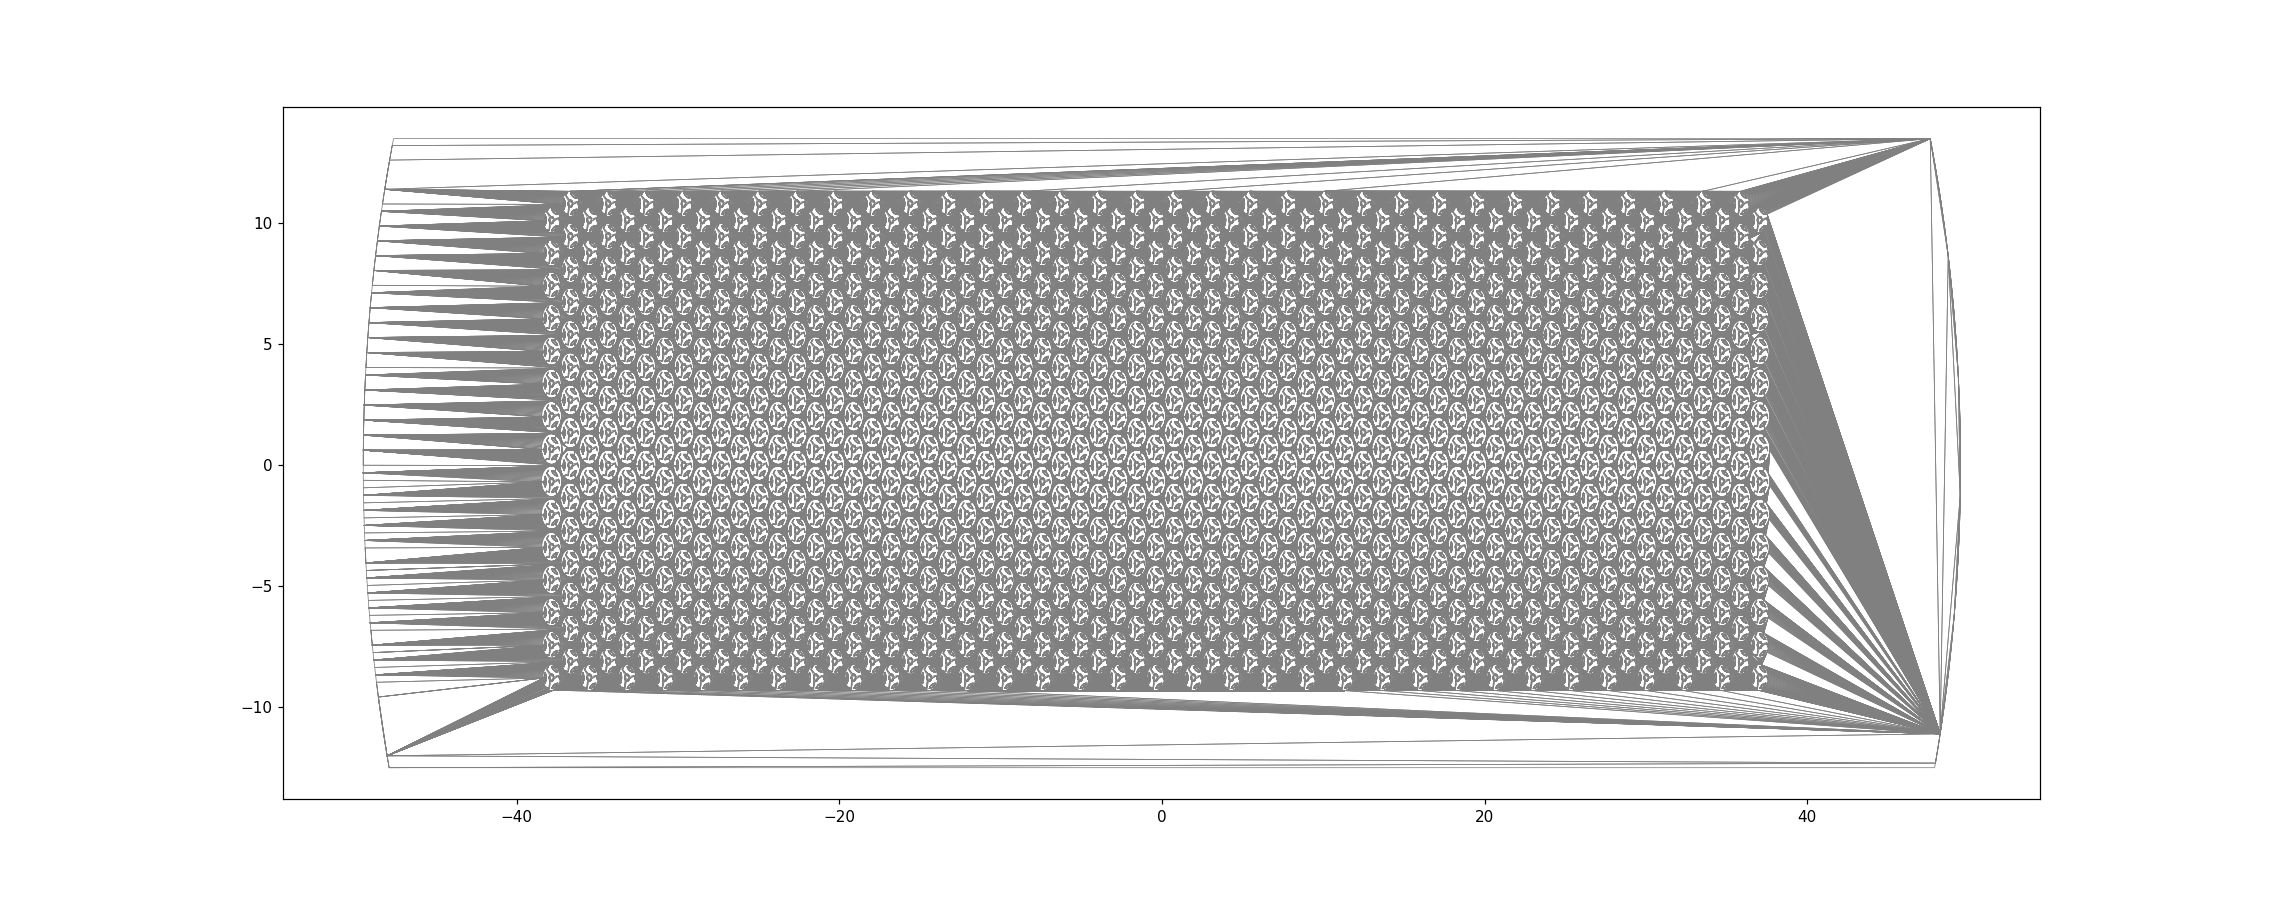

In [52]:
%matplotlib notebook
plot_triangulation(vertices, triangles)

In [54]:
filename_write = ".\\models\\top_metal_single\\top_metal.obj"

wafer_string = "o 0\n"
for i in range(int(len(vertices)/2.+0.1)):
    wafer_string += f"v {vertices[2*i]} {vertices[2*i+1]} 0.0\n"
for i in range(int(len(triangles)/3. + 0.1)):
    wafer_string += f"f {triangles[3*i]} {triangles[3*i+1]} {triangles[3*i+2]}\n"

with open(filename_write, 'w') as file:
    file.write(wafer_string[:-1])